#  Testing of Rs. 500 currency notes

This notebook carries out the complete evaluation of an input Rs. 500 currency note

In [1]:
# Importing all necessary libraries

import cv2                            # Importing Opencv library for image processing and computer vision
import numpy as np                    # Importing numpy library 
import matplotlib.pyplot as plt       # Importing matplotlib library to plot the images directly in notebook
from skimage.metrics import structural_similarity as ssim   # Importing ssim calculating modules from skimage library

# Importing tkinter library to build GUI
from tkinter import *
from tkinter.ttk import Progressbar

import time

#Resizing the Plots
plt.rcParams["figure.figsize"] = (12, 12)

In [2]:
# Declaring variable for progress bar to store the total progress
myProgress =0.0

In [3]:
# This Ipython magic will retrieve the path of the input image which is stored when the gui_1.ipynb is executed.

%store -r path

# A sample path:
# path = r'Dataset\500_dataset\500_s1.jpg'

print('Path of input image: ', path)

Path of input image:  C:/Users/admin/Desktop/Fake-Currency-Detection-System/Project_files/Dataset/500_dataset/500_s2.jpg


In [4]:
# Reading the image
test_img = cv2.imread(path)

# Pre- processing

In [5]:
# Pre- processing

# Resizing the image
test_img = cv2.resize(test_img, (1167, 519))

# Guassian Blur
blur_test_img = cv2.GaussianBlur(test_img, (5,5), 0)

# Grayscale conversion
gray_test_image = cv2.cvtColor(blur_test_img, cv2.COLOR_BGR2GRAY)

def preprocessing():
    # Showing original currency note
    plt.imshow(gray_test_image, 'gray')
    plt.title('Input image after pre- processing')
    plt.show()
    progress['value']=5
    ProgressWin.update_idletasks()
    
    # Updating the progress
    progress['value']=5
    ProgressWin.update_idletasks()

In [6]:
#  Calculating SSIM of the two images sent as parameters

def calculateSSIM(template_img, query_img):
    min_w = min(template_img.shape[1], query_img.shape[1])
    min_h = min(template_img.shape[0], query_img.shape[0])
    
    # Resizing the two images so that both have same dimensions
    img1 = cv2.resize(template_img, (min_w, min_h))
    img2 = cv2.resize(query_img, (min_w, min_h))
    
    # Conversion to gray- scale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Plotting the images
    plt.subplot(1, 2, 1)
    plt.imshow(img1, 'gray')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, 'gray')

    plt.show()
    
    # Find the SSIM score and return
    score = ssim(img1, img2)
    return score

In [7]:
# Feature detection using ORB

def computeORB(template_img, query_img):
    # ===================== Creating orb object ==============================

    nfeatures=700;
    scaleFactor=1.2;
    nlevels=8;
    edgeThreshold=15; # Changed default (31);

    # Initialize the ORB detector algorithm 
    orb = cv2.ORB_create(
        nfeatures,
        scaleFactor,
        nlevels,
        edgeThreshold)
    # =========================================================================
    
    # Find the keypoints and descriptors with ORB
    # This will find the keypoints of each of the image and then find the descriptors corresponding to each keypoint.
    
    kpts1, descs1 = orb.detectAndCompute(template_img,None)
    kpts2, descs2 = orb.detectAndCompute(query_img,None)
    
    # ====================================== Brute Force Matching ==============================
    # Starting a brute force matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Finding matches between the 2 descrptor sets
    matches = bf.match(descs1, descs2)

    # sort the matches in the order of their distance
    # Lower the distance, better the matching
    dmatches = sorted(matches, key = lambda x:x.distance)

    # ===========================================================================================
    
    # ======================================= Image homography ================================
    ## extract the matched keypoints
    src_pts  = np.float32([kpts1[m.queryIdx].pt for m in dmatches]).reshape(-1,1,2)
    dst_pts  = np.float32([kpts2[m.trainIdx].pt for m in dmatches]).reshape(-1,1,2)

    ## find homography matrix and do perspective transform
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    h,w = template_img.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    if M is not None:
        dst = cv2.perspectiveTransform(pts,M)
    else:
        dst = None

    # This finds the template region in the test currency note
    # ====================================================================================
    
    # Returning necessary data
    return dst, dst_pts, kpts1, kpts2, dmatches

In [8]:
# Values for specifying search area of features 1 to 7

search_area_list = [[200,300,200,370],
                    [1050,1500,300,450],
                    [100,450,20,120],
                    [690,1050,20,120],
                    [820,1050,350,430],
                    [700,810,330,430],
                    [400,650,0,100]]

# Values of max_area and min_area for each feature for features 1 to 7

feature_area_limits_list = [[12000,17000],
                            [10000,18000],
                            [20000,30000],
                            [24000,36000],
                            [15000,25000],
                            [7000,13000],
                            [11000,18000]]

score_set_list = []               # Stores the ssim score set of each feature
best_extracted_img_list = []      # Stores the extracted image with highest SSIM score for each feature
avg_ssim_list = []                # Stores the avg ssim value for each feature
NUM_OF_FEATURES = 7               # Number of features

In [9]:
# Algo- 1: Verification of features 1 to 7

def testFeature_1_2_7():
    i = 0
    j = 0
    NUMBER_OF_TEMPLATES = 6 
    global score_set_list                # Stores the ssim score set of each feature
    global best_extracted_img_list       # Stores the extracted image with highest SSIM score for each feature
    global avg_ssim_list                 # Stores the avg ssim value for each feature

    
    #Progress bar
    global myProgress
    myProgress =progress['value']

    
    # Iterating for each feature
    for j in range(NUM_OF_FEATURES):
        print('ANALYSIS OF FEATURE ' + str(j+1))

        score_set = []           # SSIM scores for each teamplate of current feature will be stored here
        max_score = -1           # Stores max SSIM score
        max_score_img = None     # Stores extraced image with max SSIM score for the current feature

        # Performing feature detection, extraction and comparison for each template stored in dataset 
        for i in range(NUMBER_OF_TEMPLATES):
            print('---> Template ' + str(i+1) + ' :')

            # Current template 
            template_path = r'Dataset\500_Features Dataset\Feature ' + str(j+1) + '\\' + str(i+1) + '.jpg'

            template_img = cv2.imread(template_path)

            template_img_blur = cv2.GaussianBlur(template_img, (5,5), 0)
            template_img_gray = cv2.cvtColor(template_img_blur, cv2.COLOR_BGR2GRAY)

            test_img_mask = gray_test_image.copy()

            # Creating a mask to search the current template.
            search_area = search_area_list[j]

            test_img_mask[:, :search_area[0]] = 0
            test_img_mask[:, search_area[1]:] = 0
            test_img_mask[:search_area[2], :] = 0
            test_img_mask[search_area[3]:, :] = 0

            # Feature detection using ORB 
            dst, dst_pts, kpts1, kpts2, dmatches = computeORB(template_img_gray, test_img_mask)

            # Error handling
            if dst is None:
                print('An Error occurred - Homography matrix is of NoneType')
                continue

            query_img = test_img.copy()

            # drawing polygon around the region where the current template has been detected on the test currency note -- the blue polygon
            res_img1 = cv2.polylines(query_img, [np.int32(dst)], True, (0,0,255), 1, cv2.LINE_AA)

            # draw match lines between the matched descriptors
            res_img2 = cv2.drawMatches(template_img, kpts1, res_img1, kpts2, dmatches[:20],None,flags=2)

            # Find the details of a bounding rectangle that bounds the above polygon --- green rectangle
            (x, y, w, h) = cv2.boundingRect(dst) # This gives us details about the rectangle that bounds this contour  

            # Checking if the area of the detected region is within the min and max area allowed for current feature 
            min_area = feature_area_limits_list[j][0]
            max_area = feature_area_limits_list[j][1]

            feature_area = w*h
            if feature_area < min_area or feature_area > max_area:
                (x, y, w, h) = cv2.boundingRect(dst_pts) # naya rectangle banaya

                feature_area = w*h
                if feature_area < min_area or feature_area > max_area: # If even area of 2nd rect is outside limits, then Discard 
                    # If even area of 2nd rect is outside limits, then Discard current template
                    print('Template Discarded- Area of extracted feature is outside permitted range!')
                    continue

            # Draw the rectangle
            cv2.rectangle(res_img1, (x,y), (x+w, y+h), (0,255,0), 3)

            # Plotting images
            plt.rcParams["figure.figsize"] = (16, 16)
            plt.subplot(1, 2, 1)
            plt.imshow(res_img2, 'gray')

            plt.subplot(1, 2, 2)
            plt.imshow(res_img1, 'gray')
            plt.show()

            # SSIM
            # Crop out the region inside the green rectangle (matched region)
            crop_img = blur_test_img[y:y+h, x:x+w]

            plt.rcParams["figure.figsize"] = (5, 5)
            score = calculateSSIM(template_img_blur, crop_img)

            score_set.append(score)
            print('SSIM score: ', score, '\n')

            # Keeping details about extracted region with highest SSIM score
            if score > max_score:
                max_score = score
                max_score_img = crop_img
            
            #Progress bar- Updating the progess
            myProgress = myProgress + (75.0/(NUM_OF_FEATURES*NUMBER_OF_TEMPLATES))
            progress['value'] = myProgress 
            ProgressWin.update_idletasks()
            
        # Storing necessary data
        score_set_list.append(score_set)
        print('SSIM score set of Feature ' + str(j+1) + ': ', score_set, '\n')

        avg_ssim_list.append(sum(score_set)/len(score_set))
        print('Average SSIM of Feature ' + str(j+1) + ': ',sum(score_set)/len(score_set),'\n')
        
        if len(score_set) != 0:
            avg_ssim_list.append(sum(score_set)/len(score_set))
            print('Average SSIM of Feature ' + str(j+1) + ': ',sum(score_set)/len(score_set),'\n')
        else:
            print('No SSIM scores were found for this feature!')
            avg_ssim_list.append(0.0)
            print('Average SSIM of Feature ' + str(j+1) + ': 0','\n')

        best_extracted_img_list.append([max_score_img, max_score])

    # Printing all details for features 1- 7
    print('Final Score- set list:','\n')

    for x in range(len(score_set_list)):
        print('Feature',x+1,':',score_set_list[x])
    print('\n')

    print('Final Average SSIM list for each feature:','\n')

    for x in range(len(avg_ssim_list)):
        print('Feature',x+1,':',avg_ssim_list[x])


In [10]:
left_BL_result = []
right_BL_result = []
result_list = []
number_panel_result = []

# Feature 8: Left Bleed Lines

In [11]:
# Function to count number of bleed lines in left side- Feature 8
# Algo 2

def testFeature_8():
    plt.rcParams["figure.figsize"] = (5, 5)

    # Check Feature 8- Left bleed lines
    print('\nANALYSIS OF FEATURE 8 : LEFT BLEED LINES\n')

    # Cropping the region in which left bleed lines are present- Feature extraction
    crop = test_img[120:240, 12:35]

    img = crop.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

    plt.imshow(thresh, 'gray')
    plt.show()

    whitePixelValue = 255      # White pixel   
    blackPixelValue = 0        # Black pixel

    width = thresh.shape[1]    # width of thresholded image

    # Result will be stored here
    result = []                # will contain the number of black regions in each column (if the colums is non- erroneos)
    num_of_cols = 0            # will contain the number of non- erroneos columns

    # Non erroneous columns are those columns which contains less noise.

    print('Number of black regions found in each column: ')

    # iteration over each column in the cropped image
    for j in range(width):
        col =thresh[:, j:j+1]     # Extracting each column of thresholded image
        count = 0                 # Counter to count number of black regions in each extracted column

        # Iterating over each row (or pixel) in the current columm
        for i in range(len(col)-1):

            # Taking two consecurive pixels and storing their intensity value
            pixel1_value = col[i][0]
            pixel2_value = col[i+1][0]

            #----------------------------------------------
            # This part modifies any error pixels, if present.
            # Actually in a binary threshold, all pixels should be either white or black.
            # If due to some error pixels other than white or black are present, then the pixel is taken as white pixel

            if pixel1_value != 0 and pixel1_value != 255:
                pixel1_value = 255
            if pixel2_value != 0 and pixel2_value != 255:
                pixel2_value = 255

            #-------------------------------------------------


            # If current pixel is white and next pixel is black, then increment the counter.
            # This shows that a new black region has been discovered.
            if pixel1_value == whitePixelValue and pixel2_value == blackPixelValue:
                count += 1

        # If the counter is less than 10, it is a valid column. (less noise is present)
        if count > 0 and count < 10:
            print(count)
            result.append(count)
            num_of_cols += 1
        else:
            # discard the count if it is too great e.g. count> 10 (Erroneous Column)
            # This removes/ drops those columns which contain too much noise
            print(count, 'Erroneous -> discarded')

    # Printing necessary details
    print('\nNumber of columns examined: ', width)
    print('Number of non- erroneous columns found: ', num_of_cols)

    if num_of_cols != 0:
        average_count = sum(result)/num_of_cols
    else:
        average_count = -1
        print('Error occured- Division by 0')

    print('\nAverage number of black regions is: ', average_count)

    # Storing the thresholded image and average number of bleed lines detected 
    global left_BL_result
    left_BL_result = [thresh, average_count]
    
    # Updating progess in progress bar
    global myProgress
    progress['value']=80
    ProgressWin.update_idletasks()

# Feature 9: Right Bleed Lines

In [12]:
# Function to count number of bleed lines in right side- Feature 9

def testFeature_9():
    plt.rcParams["figure.figsize"] = (5, 5)

    # Check Feature 9- Right bleed lines
    print('\nANALYSIS OF FEATURE 9 : RIGHT BLEED LINES\n')

    # Cropping the region in which left bleed lines are present- Feature extraction
    crop = test_img[120:260, 1135:1155]

    img = crop.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Thresholding the image
    _, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

    plt.imshow(thresh, 'gray')
    plt.show()

    whitePixelValue = 255      # White pixel   
    blackPixelValue = 0        # Black pixel

    width = thresh.shape[1]    # width of thresholded image

    # Result will be stored here
    result = []                # will contain the number of black regions in each column (if the colums is non- erroneos)
    num_of_cols = 0            # will contain the number of non- erroneos columns

    # Non erroneous columns are those columns which contains less noise.

    print('Number of black regions found in each column: ')

    # Iteration over each column in the cropped image
    for j in range(width):
        col =thresh[:, j:j+1]     # Extracting each column of thresholded image
        count = 0                 # Counter to count number of black regions in each extracted column

        # Iterating over each row (or pixel) in the current columm
        for i in range(len(col)-1):

            # Taking two consecurive pixels and storing their intensity value
            pixel1_value = col[i][0]
            pixel2_value = col[i+1][0]

            #----------------------------------------------
            # This part modifies any error pixels, if present.
            # Actually in a binary threshold, all pixels should be either white or black.
            # If due to some error pixels other than white or black are present, then the pixel is taken as white pixel

            if pixel1_value != 0 and pixel1_value != 255:
                pixel1_value = 255
            if pixel2_value != 0 and pixel2_value != 255:
                pixel2_value = 255

            #-------------------------------------------------

            # If current pixel is white and next pixel is black, then increment the counter.
            # This shows that a new black region has been discovered.
            if pixel1_value == whitePixelValue and pixel2_value == blackPixelValue:
                count += 1

        # If the counter is less than 10, it is a valid column. (less noise is present)
        if count > 0 and count < 10:
            print(count)
            result.append(count)
            num_of_cols += 1
        else:
            # discard the count if it is too great e.g. count> 10 (Erroneous Column)
            # This removes/ drops those columns which contain too much noise
            print(count, 'Erroneous -> discarded')

    # Printing necessary details
    print('\nNumber of columns examined: ', width)
    print('Number of non- erroneous columns found: ', num_of_cols)

    if num_of_cols != 0:
        average_count = sum(result)/num_of_cols
    else:
        average_count = -1
        print('Error occured- Division by 0')

    print('\nAverage number of black regions is: ', average_count)

    # Storing the thresholded image and average number of bleed lines detected 
    global right_BL_result
    right_BL_result = [thresh, average_count]
    global myProgress
    
    # Updating progess in progress bar
    progress['value']=85
    ProgressWin.update_idletasks()

# Feature 10: Currency Number Panel

In [13]:
# Cropping out the number panel.

# Cropping out the number panel. - FEATURE EXTRACTION

crop = gray_test_image[410:500, 700:1080]            # This is the cropped gray image
crop_bgr = test_img[410:500, 700:1080]               # This is the cropped BGR image



In [14]:
# Algo 3

def testFeature_10():
    plt.imshow(crop_bgr)
    plt.show()

    plt.rcParams["figure.figsize"] = (7, 7)

    print('\nANALYSIS OF FEATURE 10 : NUMBER PANEL \n')

    test_passed = False        # If true, then the test is successful
    res_img_list = []          # List of images of successful cases
    count = 0                  # Stores number of cases whihc are successful
    i = 0

    # THRESHOLDING at multiple values
    # Start from 95 as threshold value, increase the threshold value by 5 every time and check if 9 characters are detected in the thresholded image of number panel
    # If 9 characters are detected in at least one of the cases, the currency number panel is verified.
    # If more than 1 cases pass, the best image will be choosen from the successful cases.
    for thresh_value in range(95, 155, 5):
        # Thresholding at current value
        _, thresh = cv2.threshold(crop, thresh_value, 255, cv2.THRESH_BINARY)

        print('---> Threshold ' + str(i+1) + ' with Threshold value ' + str(thresh_value) + ' :')
        i += 1

        copy = crop_bgr.copy()

        # Finding all the contours in the image of the number panel- CONTOUR DETECTION 
        img = cv2.bitwise_and(crop, crop, mask=thresh)
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        h_img, w_img = img.shape[:2]

        # cv2.drawContours(copy, contours, -1, (0, 0, 255), 1)

        # Storing the details of all the BOUNDING RECTANGLES for each contour
        bounding_rect_list = []    

        for contour in contours:
            [x, y, w, h] = cv2.boundingRect(contour)

            if x != 0:
                bounding_rect_list.append([x,y,w,h])

        # Sorting the list of rectangles
        # Rectangles will get sorted according to the x coordinate of the top left corner
        bounding_rect_list.sort()

        # ELIMINATION OF ERRONEOUS RECTANGLES
        # Min area is taken as 150
        min_area = 150
        res_list = []

        # Storing all rectangles having area greater than the min_area in a separate list
        for i in range(0, len(bounding_rect_list)):
            if i>= len(bounding_rect_list):
                break
            if bounding_rect_list[i][2]*bounding_rect_list[i][3] > min_area:
                res_list.append(bounding_rect_list[i])

        # Eliminating the rectangles that are present within a bigger rectangle
        i = 0
        while i<len(res_list):
            [x,y,w,h] = res_list[i]
            j = i+1
            while j<len(res_list):
                [x0,y0,w0,h0] = res_list[j]

                if (x+w) >= x0+w0:
                    res_list.pop(j)
                else:
                    break
            i+= 1

        # Eliminating unnecessary rectangles
        i = 0
        while i<len(res_list):
            [x,y,w,h] = res_list[i]

            if (h_img-(y+h)) > 40:     #  Eliminating the rectangles whose lower edge is further away from lower edge of the image 
                res_list.pop(i)
            elif h<17:
                res_list.pop(i)        # Eliminating the rectangles whose height is less than 17 pixels    
            else:
                i += 1

        for rect in res_list:          # Drawing the remaining rectangles
            [x,y,w,h] = rect
            cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 1)        

        # COUNTING REMAINING RECTANGLES
        # result of each image
        if len(res_list) == 9:         # If number of rectangles detected is greater than 9, test passed
            test_passed = True
            res_img_list.append(copy)
            count += 1
            print('Test Successful: 9 letters found!')
        else:
            print('Unsuccessful!')


        # If three consecutive cases pass the test, then break 
        if count == 3:
            break

    # Choosing the BEST IMAGE to be displayed   
    # Even if a single case passes the test, then the currency number panel is verified.
    # Selecting the best image to display
    if count == 0:                    # If none of the cases passes the test
        best_img = crop_bgr
    elif count == 1:                  # If 1 case passes the test, then the image used in 1st case is selected as the best image
        best_img = res_img_list[0]
    elif count == 2:                  # If 2 cases pass the test, then the image used in 2nd case is selected as best image
        best_img = res_img_list[1]
    else:                             # If >= 3 cases pass the test, then the image used in 3rd case is selected as best image
        best_img = res_img_list[2]
    
    
    # Displaying final result

    if(test_passed):
        print('Test Passed!- 9 characters were detected in the serial number panel.')
        plt.imshow(best_img)
        plt.show()
    else:
        print('Test Failed!- 9 characters were NOT detected in the serial number panel.')

    # Storing the thresholded image and the result
    global number_panel_result
    number_panel_result = [best_img, test_passed]
    
    # Updating progress in progress bar
    global myProgress
    progress['value']=90
    ProgressWin.update_idletasks()

# Results

In [15]:
# Result analysis

def testResult():
    plt.rcParams["figure.figsize"] = (3, 3)

    print('\n\nRESULT ANALYSIS\n')

    # Stores the min allowed SSIM score for each feature
    min_ssim_score_list = [0.4, 0.4, 0.5, 0.4, 0.5, 0.45, 0.5]

    global result_list
    result_list = []               # To store details of each feature
    successful_features_count = 0  # To store number of features which passed the test

    # Feature 1 to 7: Results
    for i in range(NUM_OF_FEATURES):
        avg_score = avg_ssim_list[i]
        img, max_score = best_extracted_img_list[i]
        status = False
        min_allowed_score = min_ssim_score_list[i]

        # A feature passes the test if its avg SSIM score is greater than a min. decided value 
        # or if its max SSIM score is greater than 0.8
        if avg_score >= min_allowed_score or max_score >= 0.79:
            status = True
            successful_features_count += 1
            print('Feature ' + str(i+1) + ': Successful')
        else:
            status = False
            print('Feature ' + str(i+1) + ': Unsuccessful')
        
        if img is None:
            img = cv2.imread('Image_not_found.jpg')
        
        result_list.append([img, avg_score, max_score, status])

        
    # Feature 8: Left Bleed lines

    img, line_count = left_BL_result[:]

    # The feature passes the test if number of bleed lines is close to 7 (6.7 - 7.6)
    if line_count >= 4.7 and line_count <= 5.6:
        status = True
        successful_features_count += 1
        print('Feature 8: Successful- 5 bleed lines found in left part of currency note')
    else:
        status = False
        print('Feature 8: Unsuccessful!')
    
    if img is None:
        img = cv2.imread('Image_not_found.jpg')
    result_list.append([img, line_count, status])

    
    # Feature 9: Right Bleed lines

    img, line_count = right_BL_result[:]

    # The feature passes the test if number of bleed lines is close to 7 (6.7 - 7.6)
    if line_count >= 4.7 and line_count <= 5.6:
        status = True
        successful_features_count += 1
        print('Feature 9: Successful- 5 bleed lines found in right part of currency note')
    else:
        status = False
        print('Feature 9: Unsuccessful!')
    
    if img is None:
        img = cv2.imread('Image_not_found.jpg')
    result_list.append([img, line_count, status])

    
    # Feature 10: Currency Number Panel

    img, status = number_panel_result[:]

    # The feature passes the test if 9 characters are detected in the number panel
    if status:
        successful_features_count += 1
        print('Feature 10: Successful- 9 characters found in number panel of currency note')
    else:
        print('Feature 10: Unsuccessful!')
    
    if img is None:
        img = cv2.imread('Image_not_found.jpg')
    result_list.append([img, status])

    # printing FINAL RESULT

    print('\nResult Summary:')
    print(str(successful_features_count) + ' out of 10 features are VERIFIED!')
    
    # Updating progress bar
    global myProgress
    progress['value']=97
    ProgressWin.update_idletasks()

# Driver cell

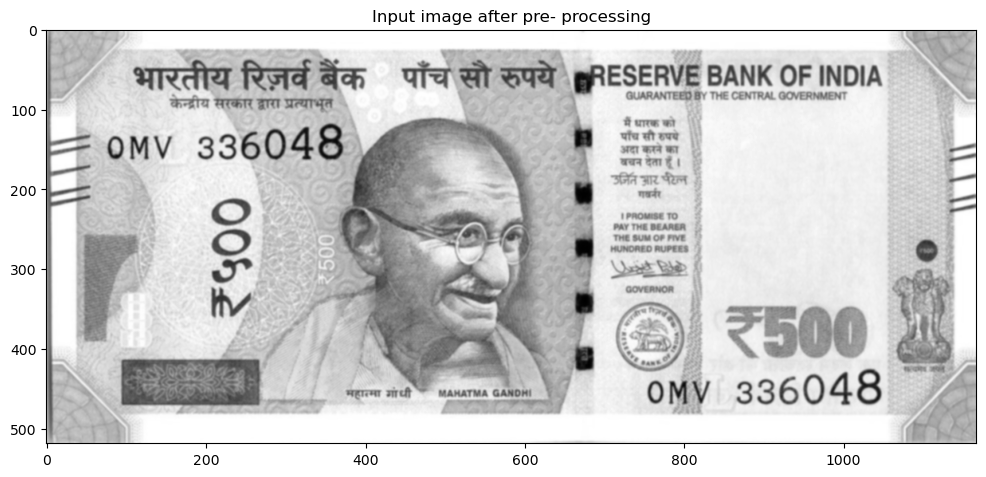

ANALYSIS OF FEATURE 1
---> Template 1 :


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_15388\3328779256.py", line 8, in Testing
    testFeature_1_2_7()
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_15388\1869151280.py", line 34, in testFeature_1_2_7
    template_img_blur = cv2.GaussianBlur(template_img, (5,5), 0)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'



In [ ]:
# creating tkinter window 

# Call all testing functions
def Testing():   
    button.config(state = DISABLED)
    result_list.clear()
    preprocessing()
    testFeature_1_2_7()
    testFeature_8()
    testFeature_9()
    testFeature_10()
    testResult()
    progress['value']=100
    ProgressWin.update_idletasks()
    time.sleep(0.8)
    ProgressWin.destroy()

def exitGUI():
    ProgressWin.destroy()

# creating tkinter window 
ProgressWin = Tk() 
ProgressWin.title("Processing Image")
ProgressWin.title('Fake Currency Detection - Processing')

# Defining attributes of root window
ProgressWin.resizable(False, False)  # This code helps to disable windows from resizing

window_height = 200
window_width = 500

screen_width = ProgressWin.winfo_screenwidth()
screen_height = ProgressWin.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

ProgressWin.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))


# Creating a main frame inside the root window
main_frame=Frame(ProgressWin,relief=GROOVE)
main_frame.place(x=10,y=10) # Placing the frame at (10, 10)

# Creating sub- frames
frame1 = Frame(main_frame, padx=3, pady=3)
frame2 = Frame(main_frame, bg='dark blue', pady=5, padx = 5)
frame3 = Frame(main_frame, pady=5, padx = 5)

frame1.grid(row = 1, column = 1, padx = 5, pady = 5)
frame2.grid(row = 2, column = 1, padx = 5, pady = 5)
frame3.grid(row = 3, column = 1, padx = 5, pady = 30)


# Title label in sub_frame1
label = Label(master=frame1, text="Processing! Please wait...", fg = 'green', font = "Verdana 13 bold")
label.pack() # Put the label into the window

# Progress bar widget 
progress = Progressbar(frame2, orient = HORIZONTAL, length = 450, mode = 'determinate') 
progress.pack()

# Button widget
button = Button(frame3, text = 'Click to continue', command = Testing, font = "Verdana 12 bold", pady = 5)
button.pack()

# Run the GUI  
ProgressWin.mainloop()

In [ ]:
# Store the list containing the final result of each feature

%store result_list